In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 9.02 MiB/s, done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [ ]:
import os

filename = [data_dir + filename for filename in os.listdir(data_dir)]
filename

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

##Preprocessing Data

In [ ]:
def get_lines(filename):
  with open(filename,"r") as f:
    return f.readlines()

In [ ]:
train_lines = get_lines(data_dir + "train.txt")
train_lines[:5]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n']

In [ ]:
len(train_lines)

210040

#converting each sentence in the list of dictionary from text file

In [ ]:
def preprocess_text_with_line_number(filename):
  """
  returns a list of dictionary of lines data

  """

  input_lines = get_lines(filename)
  abstract_lines = ''
  abstract_samples = []

  for line in input_lines:
    if line.startswith('###'):
      abstract_id = line
      abstract_lines = ''
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split('\t')
        line_data['target'] = target_text_split[0]
        line_data['text'] = target_text_split[1].lower()
        line_data['line_number'] = abstract_line_number
        line_data['total_lines'] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else:
       abstract_lines += line

  return abstract_samples

In [ ]:
#getting data from file and preprocess it
train_samples = preprocess_text_with_line_number(data_dir + 'train.txt')
val_samples = preprocess_text_with_line_number(data_dir + 'dev.txt')
test_samples = preprocess_text_with_line_number(data_dir + 'test.txt')

In [ ]:
len(train_samples), len(val_samples),len(test_samples)

(180040, 30212, 30135)

In [ ]:
train_samples[:2]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11}]

#conerting list of dictionaries in pandas dataframe

In [ ]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


<Axes: >

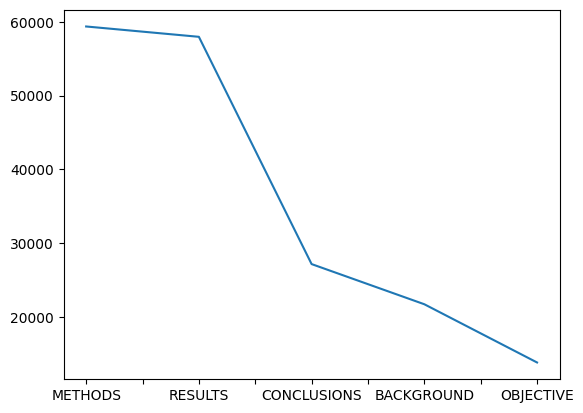

In [ ]:
train_df['target'].value_counts().plot()

##List of Sentences

In [ ]:
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

len(train_sentences),len(val_sentences),len(test_sentences)

(180040, 30212, 30135)

##Making Numerical labels

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
one_hot_encoder = OneHotEncoder(sparse=False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))

train_labels_one_hot


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
label_encoder = LabelEncoder()

train_label_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_label_encoded = label_encoder.transform(test_df['target'].to_numpy())

train_label_encoded

array([3, 2, 2, ..., 4, 1, 1])

#Class names and number of classes

In [ ]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

#Useful Function

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_result(y_true,y_pred):
  accuracy = accuracy_score(y_true,y_pred)
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
  model_results = {
      'accuracy':accuracy,
      'precision':model_precision,
      'recall':model_recall,
      'f1-score':model_f1,
  }

  return model_results

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# importing helper function
from helper_functions import create_tensorboard_callback, plot_loss_curves, pred_and_plot, unzip_data, walk_through_dir

--2023-04-22 17:22:43--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-04-22 17:22:44 (97.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



##Text Vectorization

In [ ]:
from tensorflow.keras.layers import TextVectorization, Embedding

sent_len = round(sum([len(i.split()) for i in train_sentences])/ len(train_sentences))
sent_len

26

In [ ]:
max_vocab_length = 68000
max_length = 55

text_vectorizer = TextVectorization(
    max_tokens=max_vocab_length,
    output_mode='int',
    output_sequence_length=max_length,
)

text_vectorizer.adapt(train_sentences)

# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"),
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
embedding = Embedding(
    input_dim = len(rct_20k_text_vocab),
    output_dim = 128,
    name='token_embedding'
)

#Character levelTokenizer

In [ ]:
def split_character(text):
  return ' '.join(list(text))

In [ ]:
train_chars = [split_character(sentences) for sentences in train_sentences]
val_chars = [split_character(sentences) for sentences in val_sentences]
test_chars = [split_character(sentences) for sentences in test_sentences]

In [ ]:
char_lens = [len(sentences) for sentences in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

In [ ]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation

NUM_CHAR_TOKEN = len(alphabet) + 2

char_vectorizer = TextVectorization(
    max_tokens = NUM_CHAR_TOKEN,
    output_sequence_length = output_seq_char_len,
)

char_vectorizer.adapt(train_chars)

char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")


Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


#character level embedding

In [ ]:
char_embedding = Embedding(
    input_dim = len(char_vocab),
    output_dim = 25,
    name = 'char_embed'
)

#positional embedding layer

In [ ]:
train_line_number_one_hot = tf.one_hot(train_df['line_number'].to_numpy(),depth=15)
val_line_number_one_hot = tf.one_hot(val_df['line_number'].to_numpy(),depth=15)
test_line_number_one_hot = tf.one_hot(test_df['line_number'].to_numpy(),depth=15)

train_line_number_one_hot[:5], train_line_number_one_hot.shape


(<tf.Tensor: shape=(5, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

In [ ]:
train_total_line_number_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_line_number_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_line_number_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)


train_total_line_number_one_hot[:5], train_line_number_one_hot.shape

(<tf.Tensor: shape=(5, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.]], dtype=float32)>,
 TensorShape([180040, 15]))

#Chreating tribrid inputs

In [ ]:
train_tribrid_data = tf.data.Dataset.from_tensor_slices((train_line_number_one_hot, train_total_line_number_one_hot, train_sentences, train_chars))
train_tribrid_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_tribrid_dataset = tf.data.Dataset.zip((train_tribrid_data, train_tribrid_labels))

train_tribrid_dataset = train_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_tribrid_data = tf.data.Dataset.from_tensor_slices((val_line_number_one_hot, val_total_line_number_one_hot, val_sentences, val_chars))
val_tribrid_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_tribrid_dataset = tf.data.Dataset.zip((val_tribrid_data, val_tribrid_labels))

val_tribrid_dataset = val_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
test_tribrid_data = tf.data.Dataset.from_tensor_slices((test_line_number_one_hot, test_total_line_number_one_hot, test_sentences, test_chars))
test_tribrid_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_tribrid_dataset = tf.data.Dataset.zip((test_tribrid_data, test_tribrid_labels))

test_tribrid_dataset = test_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

#Building BERT Models

In [ ]:
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 75.9 MB/s eta 0:00:00


In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text

preprocess = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert = hub.load('https://tfhub.dev/google/experts/bert/pubmed/2')

In [ ]:
preprocess_layer = hub.KerasLayer(preprocess, name='bert_input_preprocess')
bert_layer = hub.KerasLayer(bert,name='bert_layer')

In [ ]:
# 1. token inputs
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_inputs', ragged=False)
bert_input = preprocess_layer(token_inputs)
bert_outputs = bert_layer(bert_input, training=False)
sequence_output = bert_outputs['pooled_output']
token_outputs = layers.Dense(128, activation='relu')(sequence_output)
token_model = tf.keras.Model(token_inputs, token_outputs)

# 2. Charater imputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input', ragged=False)
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. model for line_number feature
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name='line_numbers_input')
line_number_outputs = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, line_number_outputs)

# 4. model for total_line feature
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name='total_line_inputs')
total_lines_outputs = layers.Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, total_lines_outputs)

# 5. Concat layer 1 & 2
token_char_concat = layers.Concatenate(name='concat_layer')([token_model.output,
                                                             char_model.output])

# adding one dropout layer
z = layers.Dense(256, activation='relu')(token_char_concat)
z = layers.Dropout(0.5)(z)

# 6. concat layers 3 4 5
final_concat = layers.Concatenate(name='final_concat')([
    line_number_model.output,
    total_lines_model.output,
    z
])

# Output layer
output_layer = layers.Dense(num_classes, activation='softmax', name='output_layer')(final_concat)

# final model
model = tf.keras.Model(
    inputs = [
              line_number_model.input,
              total_lines_model.input,
              token_model.input,
              char_model.input,
    ],
    outputs = output_layer
)

In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 bert_input_preprocess (KerasLa  {'input_type_ids':   0          ['token_inputs[0][0]']           
 yer)                           (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                    

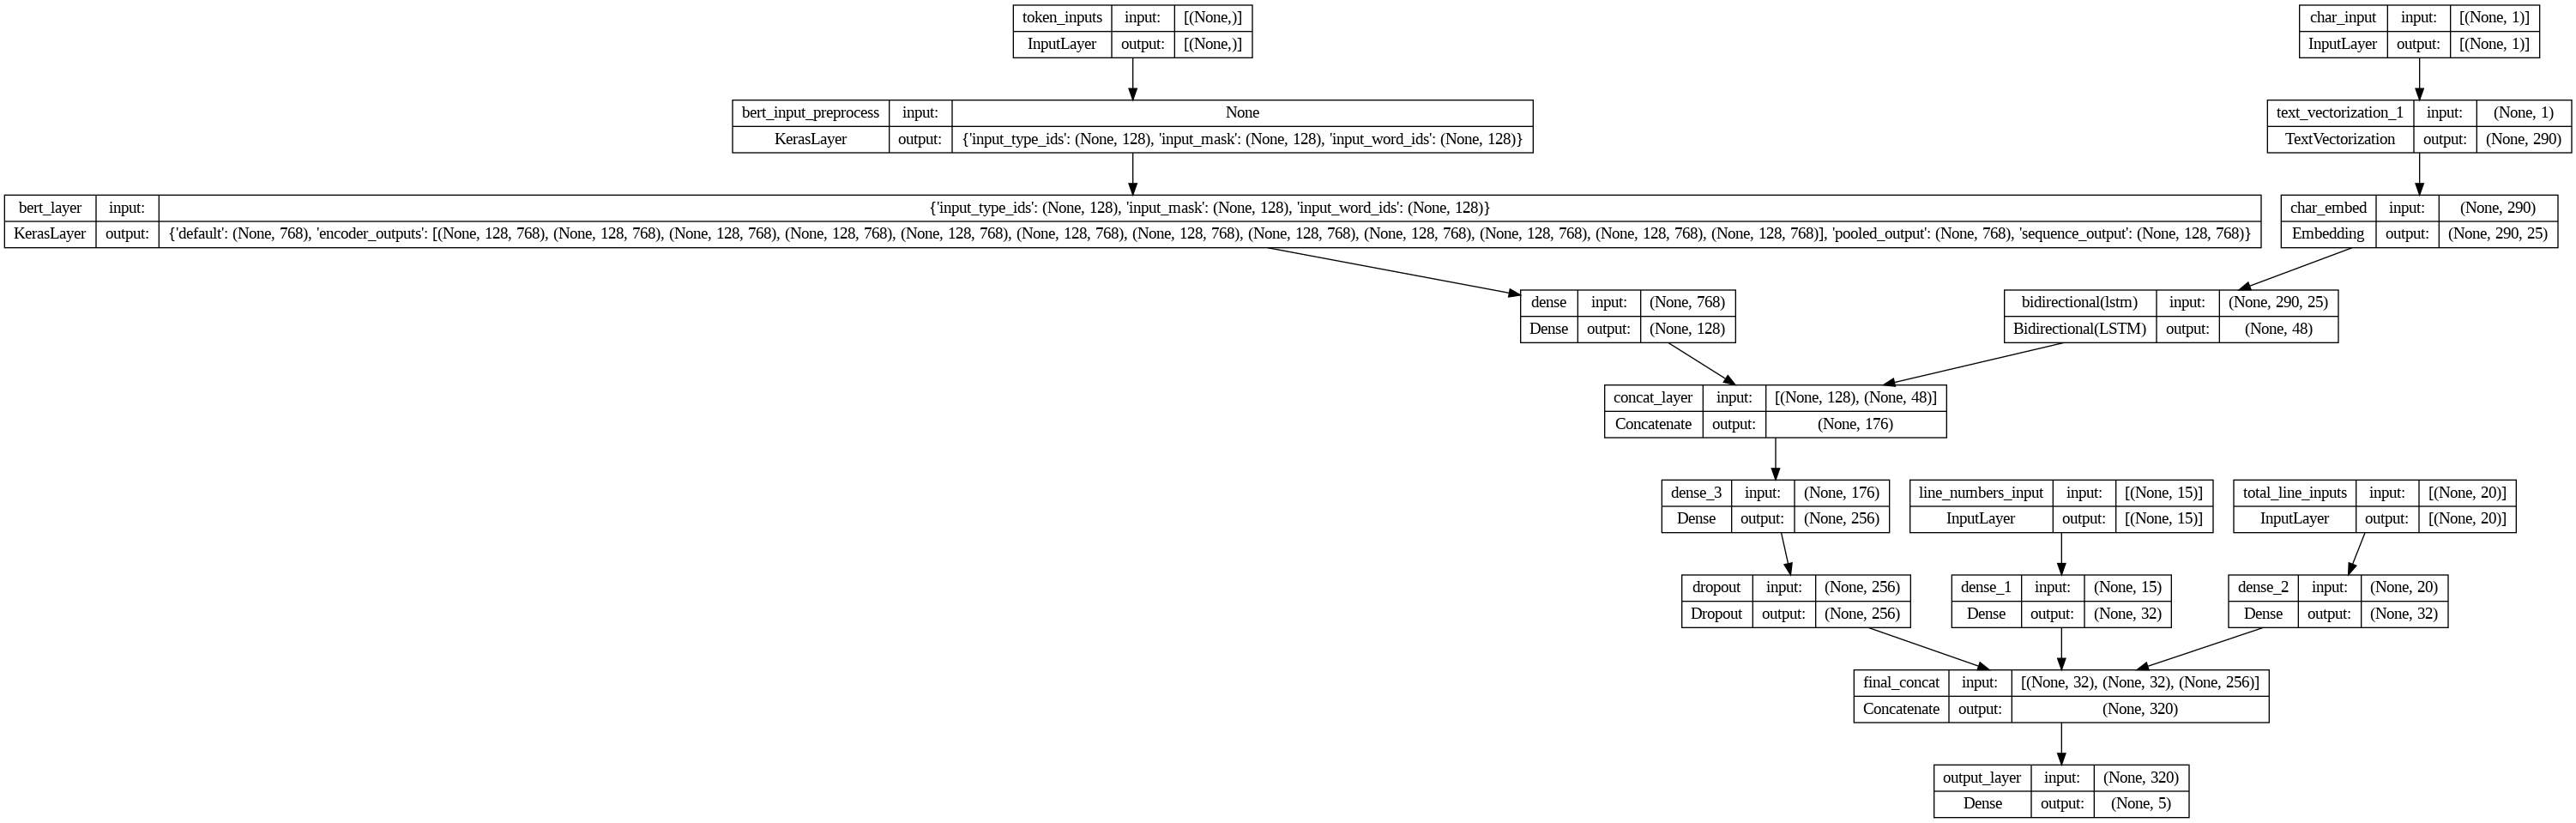

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
    optimizer = Adam(),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_tribrid_dataset,
    epochs = 3,
    steps_per_epoch = len(train_tribrid_dataset),
    validation_data = val_tribrid_dataset,
    validation_steps = int(0.15 * len(val_tribrid_dataset)),
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Datasets/SkimLit/model/bert_model_2', save_best_only=True)
    ]
)

Epoch 1/3
5627/5627 [==============================] - ETA: 0s - loss: 0.8847 - accuracy: 0.8706

5627/5627 [==============================] - 2152s 379ms/step - loss: 0.8847 - accuracy: 0.8706 - val_loss: 0.8527 - val_accuracy: 0.8825
Epoch 2/3
5627/5627 [==============================] - ETA: 0s - loss: 0.8555 - accuracy: 0.8869

5627/5627 [==============================] - 2134s 379ms/step - loss: 0.8555 - accuracy: 0.8869 - val_loss: 0.8420 - val_accuracy: 0.8903
Epoch 3/3
5627/5627 [==============================] - 2106s 374ms/step - loss: 0.8498 - accuracy: 0.8898 - val_loss: 0.8439 - val_accuracy: 0.8887


In [ ]:
#Evaluating model on validation Data

In [ ]:
bert_model = tf.keras.models.load_model('/content/drive/MyDrive/Datasets/SkimLit/model/bert_model_2')

In [ ]:
#Saving Model

In [ ]:
bert_model.save('Skimlit_BertModel')

In [ ]:
loaded_model = tf.keras.models.load_model('/content/Skimlit_BertModel')

In [ ]:
!zip -r /content/Skimlit_BertModel.zip /content/Skimlit_BertModel

  adding: content/Skimlit_BertModel/ (stored 0%)
  adding: content/Skimlit_BertModel/assets/ (stored 0%)
  adding: content/Skimlit_BertModel/assets/vocab.txt (deflated 53%)
  adding: content/Skimlit_BertModel/saved_model.pb (deflated 92%)
  adding: content/Skimlit_BertModel/variables/ (stored 0%)
  adding: content/Skimlit_BertModel/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/Skimlit_BertModel/variables/variables.index (deflated 79%)
  adding: content/Skimlit_BertModel/keras_metadata.pb (deflated 89%)
  adding: content/Skimlit_BertModel/fingerprint.pb (stored 0%)


In [ ]:
#Testing Model on test data

In [ ]:
loaded_model.evaluate(test_tribrid_dataset)

942/942 [==============================] - 332s 351ms/step - loss: 0.8532 - accuracy: 0.8837


[0.8532249927520752, 0.8836568593978882]